In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from math import sqrt
import pickle

data = pd.read_pickle('../data/data_AIS_climate.pickle')
len(data)

6618

# Preparación datasets de entrenamiento y test

In [2]:
# separar dataset de entrenamiento de dataset de test
# Output: df_data_test, df_data_train


# Paso 1: Listas que contiene rutas de entrenamiento y test
size_data_test = round(len(data) * 0.2)

data_test = []
for i in range(0, size_data_test):
    data_test.append(data[i])    

    
data_train = []
for i in range(size_data_test, len(data)):
    data_train.append(data[i]) 
    

# Paso 2: Dataframe que contiene las rutas de entrenamiento y test
data_test_routes = []
for route in data_test:
    data_test_routes.append(pd.DataFrame(route))
    
df_data_test = pd.concat(data_test_routes, ignore_index=True)
df_data_test.info()


data_train_routes = []
for route in data_train:
    data_train_routes.append(pd.DataFrame(route))
    
df_data_train = pd.concat(data_train_routes, ignore_index=True)
df_data_train.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734351 entries, 0 to 734350
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   FECHA          734351 non-null  datetime64[ns]
 1   LATITUD        734351 non-null  float64       
 2   LONGITUD       734351 non-null  float64       
 3   VELOCIDAD      734351 non-null  float64       
 4   distance       734351 non-null  float64       
 5   Av.Speed       734351 non-null  float64       
 6   Time_Av.Speed  734351 non-null  float64       
 7   ChangeInSpeed  734351 non-null  float64       
 8   length         734351 non-null  int64         
 9   width          734351 non-null  int64         
 10  to_Arrive      734351 non-null  float64       
 11  WaterTemp      734351 non-null  int64         
 12  WindSpeed      734351 non-null  int64         
 13  WinDir         734351 non-null  int64         
 14  PrecipMM       734351 non-null  float64       
 15  

<ipython-input-2-2cab35440c5c>:32: FutureWarning: null_counts is deprecated. Use show_counts instead
  df_data_train.info(null_counts=True)


In [3]:
df_data_train = df_data_train.rename(columns={'LATITUD': 'Latitude', 'LONGITUD': 'Longitude', 'VELOCIDAD':'Speed', 'distance':'Distance', 'length':'Length', 'width':'Width'})
df_data_test = df_data_test.rename(columns={'LATITUD': 'Latitude', 'LONGITUD': 'Longitude', 'VELOCIDAD':'Speed', 'distance':'Distance', 'length':'Length', 'width':'Width'})

#df_data_train.info(null_counts=True)
#df_data_test.info(null_counts=True)

# Entrenamiento del algoritmo

In [4]:
# Selección de features
X_test = df_data_test[['Longitude', 'Latitude', 'Speed', 'Distance', 'Length', 'Width', 'WinDir']]  #,'WinDir'
y_test = df_data_test["to_Arrive"].values.reshape(-1, 1)

X_train = df_data_train[['Longitude', 'Latitude', 'Speed', 'Distance', 'Length', 'Width', 'WinDir']]
y_train = df_data_train["to_Arrive"].values.reshape(-1, 1)

# Escalado de features
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)

X_test = X_scaler.fit_transform(X_test)
y_test = y_scaler.fit_transform(y_test)

In [5]:
# Entrenamiento
model = KNeighborsRegressor(n_neighbors=180)
print(model)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=70, p=2,
          weights='uniform') 

model.fit(X_train,y_train)

y_test_hat = model.predict(X_test)
print('Empezando a entrenar test de entrenamiento')
y_train_hat = model.predict(X_train)

KNeighborsRegressor(n_neighbors=180)
Empezando a entrenar test de entrenamiento


# Validation metrics

In [6]:
from sklearn.metrics import r2_score
# Calculamos el error
print("Entrenamiento", r2_score(y_train, y_train_hat))
print("Prueba", r2_score(y_test, y_test_hat))

Entrenamiento 0.8342925395572038
Prueba 0.5714366370248877


In [7]:
y_test = y_scaler.inverse_transform(y_test)
y_test_hat = y_scaler.inverse_transform(y_test_hat)

mae = mean_absolute_error(y_test, y_test_hat)
print("Mean Absolute Error:",mae)

Mean Absolute Error: 25.112029413084983


In [8]:
mse =mean_squared_error(y_test, y_test_hat)
print("Mean Squared Error:",mse)

Mean Squared Error: 1947.5639370621814


In [9]:
rmse = sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 44.131212730472086


In [10]:
error = y_test_hat - y_test

C:\Users\usuario\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


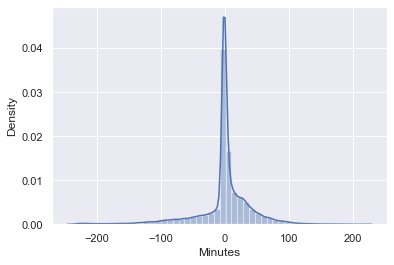

In [11]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.distplot(error, axlabel='Minutes')

In [ ]:
import matplotlib.pyplot as plt
X_test = X_scaler.inverse_transform(X_test)   
distance = X_test[:,5]
errors = abs(y_test_hat - y_test)
 
# plotting
plt.title("Distance vs Error")
plt.xlabel("Distance")
plt.ylabel("Error")
plt.scatter(distance, errors, color ="red")
plt.show()

# Guardar modelo

In [13]:
pickle.dump(model, open('models/knn_weather_model_180.sav', 'wb'))
pickle.dump(X_scaler, open('models/knn_weather_X_scaler.sav', 'wb'))
pickle.dump(y_scaler, open('models/knn_weather_y_scaler.sav', 'wb'))

# Error rate for different k values

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(100,200,50):
#for K in range(200,500,20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)
    
    KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=K, p=2,
          weights='uniform')

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    #print('RMSE value for k= ' , K , 'is:', error)

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) 
curve.plot()